# Value at Risk prediction using Random Forest and LightGBM

**Value at Risk (VaR)** is an estimate of how much an investment portfolio might lose with a given confidence interval on a specific period of time. Here, we will focus on estimating the one day 95% VaR on a portfolio composed only by **S&P500 shares**. 
<br>(Let's assume that the one day 95% VaR is X%; that means that over a trading year of 252 days  I expect to incur in losses equal or greater than X% of my investment value in 5% of the cases, namely 12,6 trading days)

In this project we will estimate the VaR using **Machine Learning based approaches** (**Random Forest** and **LightGBM**). We will then compare the performance of these models with **Historical Simulation** which relies on a more traditional approach to VaR computation.

The project is divided in three sections:
<br> **1. Data preparation**
<br> **2. Model training & Validation**
<br> **3. Backtest**

## 1. Data preparation

We will download the daily closing prices of the S&P500 index from Yahoo Finance from 2018-01-01 to 2019-12-31. We will then compute the **daily log return** and the **95% actual VaR** at time *t* as the fifth quantile in the daily log return distribution from day *t-30-1* to day *t* (included). 
<br> Then we will transform the time series of VaR values in **tabular form**: the actual VaR at day *t* will be our response variable and the VaR at day *t-1* the regressor.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SeP500_df = yf.download('^GSPC', 
                   start='2018-01-01',
                   end = '2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [3]:
SeP500_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000


In [4]:
len(SeP500_df)

502

In [5]:
# Compute lof returns
SeP500_df['Return'] = SeP500_df.Close.pct_change()
SeP500_df['Log_return'] = np.log(1 + SeP500_df.Return)
SeP500_df = SeP500_df.dropna(axis = 0)

In [6]:
# Compute actual VaR
VaR_actual = [0] * 29

for i in range(len(SeP500_df.Log_return) - 29):
    x = SeP500_df.Log_return[i : i + 30].quantile(q = 0.05, interpolation = 'nearest')
    VaR_actual.append(x)

In [7]:
len(VaR_actual), len(SeP500_df)

(501, 501)

In [8]:
# Join the observed VaR vector to the log return dataframe
pd.options.mode.chained_assignment = None  # default='warn'
SeP500_df['VaR_actual'] = VaR_actual

In [19]:
SeP500_df.to_excel(excel_writer=r'C:\Users\Luifi Zhang\Desktop\file.xlsx')

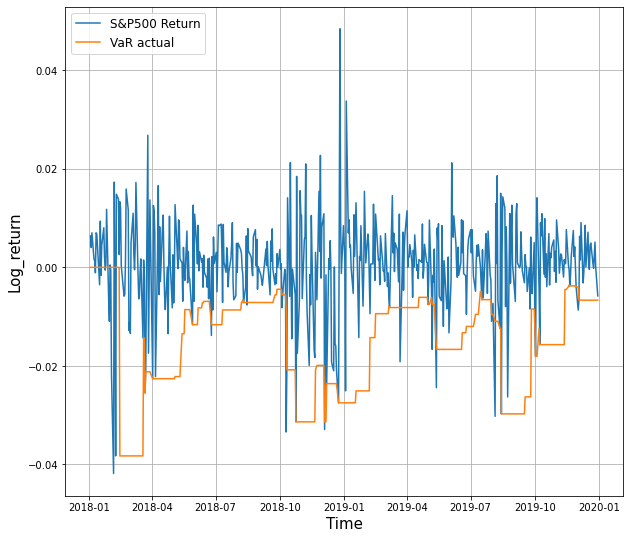

In [9]:
# Plot log returns and VaR

plt.figure(figsize = (10,9))
plt.plot(SeP500_df.index, SeP500_df['Log_return'], label = 'S&P500 Return', linewidth=  1.5, linestyle = '-')
#plt.plot(SeP500_df.index, SeP500_df['VaR_actual_new'], label = "VaR actual", linewidth=  1.5, linestyle = '-')
plt.plot(SeP500_df.index, SeP500_df['VaR_actual'], label = "VaR actual", linewidth=  1.5, linestyle = '-')
plt.grid(True)
plt.ylabel('Log_return', color = 'black', size = 15)
plt.xlabel('Time', color = 'black', size = 15)
plt.legend(loc= 'upper left', fontsize = 12)
plt.show()

In [10]:
# Remove rows where VaR = 0 (missing)
df = SeP500_df[(SeP500_df["VaR_actual"] != 0)]

In [11]:
# Transform the time series dataset in tabular form 
df['VaR_previous_day'] = df['VaR_actual'].shift(periods = 1) #VaR Actual is target variable y, Var_previous_day is the regressor X

In [12]:
df_2 = df[['VaR_previous_day', 'VaR_actual']]

In [13]:
len(df_2)

472

In [14]:
def train_val_split(n_train):
    global X_train, X_val, y_train, y_val
    X_train = np.array(df_2.VaR_previous_day[1 : n_train]).reshape(-1, 1) #(1:200)
    X_val = np.array(df_2.VaR_previous_day[n_train + 1 :]).reshape(-1, 1) #(201: 252)
    y_train = np.array(df_2.VaR_actual[1 : n_train])
    y_val = np.array(df_2.VaR_actual[n_train + 1 :])
    return len(X_train), len(y_train), len(X_val), len(y_val)

In [15]:
train_val_split(400)

(399, 399, 71, 71)

## 2. Model training & Validation

After creating the dataset, we are ready to train our models.
<br> We will use three models to make our prediction: **Random Forest**, **LightGBM** and **Historical Simulation**.
<br>**Random Forest** and **LightGBM** are two supervised Machine Learning algorithms based on decision trees. In order to find the best combinations of **hyperparameters** we will use the optimizations algorithm in the **Optuna** package instead of the traditional Grid Search. Finally, in order to make the most accurate predictions we will bw using the one step **Walk Forward Validation** method by including in the training set the previous day's observed VaR (at day *t+2* we will retrain the model on the training set and the observed value of the response variable at time *t* and *t+1*). 

<br>Finally with the **Historical Simulation** method we assume that the distribution of returns computed from historical data is a good approximation of the distribution of future returns. In this case we essentially take the historical *n* returns of the latest *n* periods and sort them from smallest to largest. The 95% VaR at time *n+1* is the quantile that corresponds to
the desired level of confidence, 95%. if *n* = 100, the 95% VaR at day 101 is the fifth smallest observation out of 100.

In [54]:
# Optuna for hyperparameters search
import optuna
from sklearn.metrics import mean_squared_error

### 2.1 Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
def objective(trial):
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    n_estimators = trial.suggest_int('n_estimators', low = 50, high = 600, step = 50)
    min_samples_split = trial.suggest_int('min_samples_split', low = 2, high = 22, step = 5)
    max_depth = trial.suggest_int('max_depth', low = 1, high = 31, step = 5)
    min_samples_leaf = trial.suggest_int(' min_samples_leaf', low = 1, high = 16, step = 5)

    # define model
    rf = RandomForestRegressor(max_features = max_features, 
                             n_estimators = n_estimators, 
                             min_samples_split = min_samples_split,
                             max_depth = max_depth,
                             min_samples_leaf = min_samples_leaf
                             )
    rf.fit(X_train[0:350], y_train[0:350]) # use first 351 observations of train set to train model
    y_pred_1 = rf.predict(X_train[350:]) # use the remaining observations of train for validation
    # minimize the following metric
    return mean_squared_error(y_train[350:], y_pred_1) # MSE on validation

In [57]:
study_rf = optuna.create_study(direction = 'minimize')
study_rf.optimize(objective, n_trials = 300)

[I 2022-11-23 16:21:41,925] A new study created in memory with name: no-name-ac087efa-30c7-40d0-8d3c-b0760bae725a
[I 2022-11-23 16:21:43,038] Trial 0 finished with value: 8.091488738601794e-06 and parameters: {'max_features': 'log2', 'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 11, ' min_samples_leaf': 1}. Best is trial 0 with value: 8.091488738601794e-06.
[I 2022-11-23 16:21:43,700] Trial 1 finished with value: 8.018397128808864e-06 and parameters: {'max_features': 'sqrt', 'n_estimators': 300, 'min_samples_split': 17, 'max_depth': 16, ' min_samples_leaf': 11}. Best is trial 1 with value: 8.018397128808864e-06.
[I 2022-11-23 16:21:44,842] Trial 2 finished with value: 8.038256250928656e-06 and parameters: {'max_features': 'sqrt', 'n_estimators': 600, 'min_samples_split': 17, 'max_depth': 26, ' min_samples_leaf': 1}. Best is trial 1 with value: 8.018397128808864e-06.
[I 2022-11-23 16:21:45,490] Trial 3 finished with value: 8.06827331809753e-06 and parameters: {'max_features'

In [58]:
print(f' The best combination of hyperparameters is :{study_rf.best_params}')
print(f' The MSE is: {study_rf.best_trial.value}')

 The best combination of hyperparameters is :{'max_features': 'auto', 'n_estimators': 50, 'min_samples_split': 17, 'max_depth': 21, ' min_samples_leaf': 6}
 The MSE is: 7.751881041933136e-06


In [59]:
# Refit model with optimal combination of hyperparameters
rf_reg = RandomForestRegressor(  max_features = 'auto', 
                                 n_estimators = 50, 
                                 min_samples_split = 17,
                                 max_depth = 21,
                                 min_samples_leaf = 6,
                                 random_state = 42)

In [60]:
# One step Walk Forward Validation
y_pred_rf = []

for i in range(len(y_val)):
    rf_reg.fit(X_train, y_train)
    pred = rf_reg.predict([X_val[i]])
    X_train = np.append(X_train, [X_val[i]]).reshape(-1,1)
    y_train = np.append(y_train, [y_val[i]])
    y_pred_rf.append(pred)

In [61]:
mean_squared_error(y_val, y_pred_rf)

7.476285532839023e-06

In [62]:
len(X_train)

470

### 2.2 LightGBM

In [63]:
from lightgbm import LGBMRegressor

In [64]:
# Split dataset
train_val_split(400)

(399, 399, 71, 71)

In [65]:
def objective(trial):
  num_leaves = trial.suggest_int('num_leaves', low = 21, high = 41, step = 5)
  learning_rate = trial.suggest_float(' learning_rate', low = 0.1, high = 0.5, step = 0.1)
  colsample_bytree = trial.suggest_float('colsample_bytree', low = 0.4, high = 1, step = 0.1)
  n_estimators = trial.suggest_int('n_estimators', low = 50, high = 600, step = 50)
  min_child_samples = trial.suggest_int('min_child_samples', low = 15, high = 30, step = 5)
  max_depth = trial.suggest_int('max_depth', low = -1, high = 29, step = 5)

  # define model
  lgbm = LGBMRegressor(num_leaves = num_leaves, 
                        learning_rate = learning_rate, 
                        colsample_bytree = colsample_bytree, # the subsample ratio of columns when constructing each tree
                        n_estimators = n_estimators, 
                        min_child_samples = min_child_samples,
                        max_depth = max_depth,
                        )
  lgbm.fit(X_train[0:350], y_train[0:350]) # use first 351 observations of train set to train model
  y_pred_1 = lgbm.predict(X_train[350:]) # use the remaining observations of train for validation
  # metrica da minimizzare
  return mean_squared_error(y_train[350:], y_pred_1) # MSE on validation

In [66]:
study_lgbm = optuna.create_study(direction = 'minimize')
study_lgbm.optimize(objective, n_trials = 300)

[I 2022-11-23 16:26:14,577] A new study created in memory with name: no-name-af7acb36-4d27-449e-b14d-4df451eb067f
[I 2022-11-23 16:26:14,924] Trial 0 finished with value: 8.202498768864494e-06 and parameters: {'num_leaves': 31, ' learning_rate': 0.5, 'colsample_bytree': 0.7000000000000001, 'n_estimators': 600, 'min_child_samples': 20, 'max_depth': 19}. Best is trial 0 with value: 8.202498768864494e-06.
[I 2022-11-23 16:26:15,068] Trial 1 finished with value: 1.6573211205600063e-05 and parameters: {'num_leaves': 21, ' learning_rate': 0.2, 'colsample_bytree': 1.0, 'n_estimators': 400, 'min_child_samples': 30, 'max_depth': 29}. Best is trial 0 with value: 8.202498768864494e-06.
[I 2022-11-23 16:26:15,121] Trial 2 finished with value: 8.19832135689603e-06 and parameters: {'num_leaves': 21, ' learning_rate': 0.2, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 50, 'min_child_samples': 20, 'max_depth': 9}. Best is trial 2 with value: 8.19832135689603e-06.
[I 2022-11-23 16:26:15,303] 

In [67]:
print(f' The best combination of hyperparameters is :{study_lgbm.best_params}')
print(f' The MSE is: {study_lgbm.best_trial.value}')

 The best combination of hyperparameters is :{'num_leaves': 31, ' learning_rate': 0.1, 'colsample_bytree': 0.4, 'n_estimators': 50, 'min_child_samples': 20, 'max_depth': 29}
 The MSE is: 8.05158387373118e-06


In [68]:
# Refit model with optimal combination of hyperparameters
lgbm_reg = LGBMRegressor(num_leaves = 31, 
                        learning_rate = 0.1, 
                        colsample_bytree = 0.4, # the subsample ratio of columns when constructing each tree
                        n_estimators = 50, 
                        min_child_samples = 20,
                        max_depth = 29,
                        random_state = 42
                        )

In [69]:
# One step Walk Forward Validation
y_pred_lgbm = []

for i in range(len(y_val)):
    lgbm_reg.fit(X_train, y_train)
    pred = lgbm_reg.predict([X_val[i]])
    X_train = np.append(X_train, [X_val[i]]).reshape(-1,1)
    y_train = np.append(y_train, [y_val[i]])
    y_pred_lgbm.append(pred)

In [70]:
mean_squared_error(y_val, y_pred_lgbm)

7.724633160910489e-06

In [71]:
len(X_train)

470

### 2.3 Historical Simulation - 30 days

In [72]:
VaR_30gg = [0] * 30

for i in range(len(SeP500_df.Log_return) - 30):
    x = SeP500_df.Log_return[i : i + 30].quantile(q = 0.05, interpolation = 'nearest') # Il VaR del trentunesimo giorno è uguale al VaR dei trenta giorni precedenti.
    VaR_30gg.append(x)

In [73]:
VaR_30gg_df = pd.DataFrame(VaR_30gg, columns = ['VaR_30gg'])

In [74]:
y_pred_hs = VaR_30gg[-71:] # Take the last 71 elements as predictions

In [75]:
mean_squared_error(y_val, y_pred_hs)

7.647109957181081e-06

## 3. Backtest

Finally we will evaluate the performances of the three selected models by conducting **Kupiec's Proportion of Failure (POF) Test**.
<br> With the POF test we can test if the frequency of the actual VaR violations (number of days where losses exceed predicted VaR) is statistically different from the theoretical one which we can compute as <br> *validation set size * 5%* = 71 days * 5% = 4 days. (In other words we expect 4 days in which the estimated VaR will be violated).


Under the null hypothesis, the test statistic is distributed as a chi-squared distribution with one degree of freedom

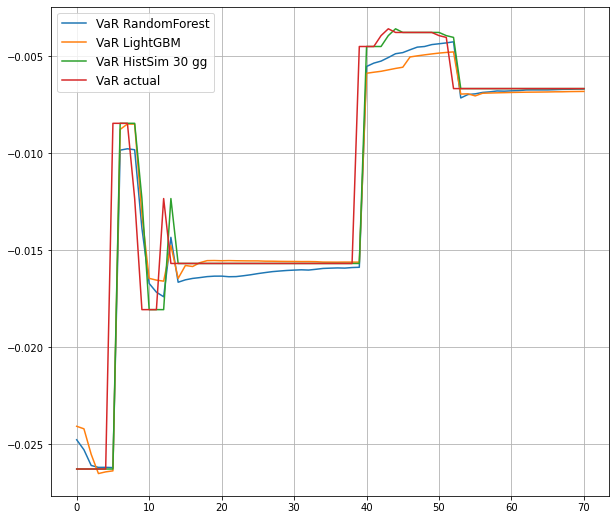

In [76]:
plt.figure(figsize = (10,9))
plt.plot(y_pred_rf, label = 'VaR RandomForest', linewidth=  1.5, linestyle = '-')
plt.plot(y_pred_lgbm, label = "VaR LightGBM", linewidth=  1.5, linestyle = '-')
plt.plot(y_pred_hs, label = "VaR HistSim 30 gg", linewidth=  1.5, linestyle = '-')
plt.plot(y_val, label = "VaR actual", linewidth=  1.5, linestyle = '-')
plt.grid(True)
plt.legend(loc= 'upper left', fontsize = 12)
plt.show()

In [77]:
# Test di Kupiec
def kupiec_test(alpha, VaR_violations):
    import scipy.stats
    
    a = alpha
    x = VaR_violations.sum()
    n = len(VaR_violations)
    pi = x / n

    num = (a**(x))*((1 - a)**(n - x))
    den = (pi**(x))*((1 - pi)**(n - x))

    test_statistic_value = -2 * np.log(num / den)
    critical_value = scipy.stats.chi2.ppf(1-alpha, df = 1)
    
    if test_statistic_value > critical_value:
        test_output = 'Null hypotheses is rejected'
    else:
        test_output = 'Null hypotheses is accepted'
        
    Null_hypotheses = f'Probability of losses exceeding VaR is {alpha}'
    
    expected_failures = alpha * n
        
    dictionary = {'Null hypotheses' : Null_hypotheses,
                  'Number of observed days' : n,
                  'Number of actual VaR failures' : x,
                  'Number of expected VaR failures': expected_failures,
                  'Test statistic value': test_statistic_value,
                  'Chi2 critical value': critical_value,
                  'Test_output' : test_output}
    return dictionary

### Random Forest

In [78]:
rf_dictionary = {'Log_return' : df.Log_return[-71:], 'VaR_predicted' : y_pred_rf}

In [79]:
rf_check_VaR = pd.DataFrame(rf_dictionary)
rf_check_VaR['Violation'] = np.where(rf_check_VaR['Log_return'] < rf_check_VaR['VaR_predicted'], 1, 0)

In [80]:
kupiec_test(0.05, rf_check_VaR['Violation'])

{'Null hypotheses': 'Probability of losses exceeding VaR is 0.05',
 'Number of observed days': 71,
 'Number of actual VaR failures': 5,
 'Number of expected VaR failures': 3.5500000000000003,
 'Test statistic value': 0.5563001266589697,
 'Chi2 critical value': 3.841458820694124,
 'Test_output': 'Null hypotheses is accepted'}

### LightGBM

In [81]:
lgbm_dictionary = {'Log_return' : df.Log_return[-71:], 'VaR_predicted' : y_pred_lgbm}

In [82]:
lgbm_check_VaR = pd.DataFrame(rf_dictionary)
lgbm_check_VaR['Violation'] = np.where(rf_check_VaR['Log_return'] < rf_check_VaR['VaR_predicted'], 1, 0)

In [84]:
kupiec_test(0.05, lgbm_check_VaR['Violation'])

{'Null hypotheses': 'Probability of losses exceeding VaR is 0.05',
 'Number of observed days': 71,
 'Number of actual VaR failures': 5,
 'Number of expected VaR failures': 3.5500000000000003,
 'Test statistic value': 0.5563001266589697,
 'Chi2 critical value': 3.841458820694124,
 'Test_output': 'Null hypotheses is accepted'}

### Simulazione Storica - 30gg

In [85]:
hs_dictionary = {'Log_return' : df.Log_return[-71:], 'VaR_predicted' : y_pred_hs}

In [86]:
hs_check_VaR = pd.DataFrame(hs_dictionary)
hs_check_VaR['Violation'] = np.where(hs_check_VaR['Log_return'] < hs_check_VaR['VaR_predicted'], 1, 0)

In [87]:
kupiec_test(0.05, hs_check_VaR['Violation'])

{'Null hypotheses': 'Probability of losses exceeding VaR is 0.05',
 'Number of observed days': 71,
 'Number of actual VaR failures': 7,
 'Number of expected VaR failures': 3.5500000000000003,
 'Test statistic value': 2.785027728307944,
 'Chi2 critical value': 3.841458820694124,
 'Test_output': 'Null hypotheses is accepted'}

As we can see from the results, the machine learning approaches outperformed Historical Simulation:
<br> - for both **Random Forest** and **LightGBM** losses were greater than the predicted VaR values in 5 instances (5 VaR violations)
<br> - for **Historical Simulation** losses were greater than the predicted VaR values in 7 instances (7 VaR violations).